In [1]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pandas as pd
import netCDF4
%matplotlib inline

In [3]:
areacella1 = xr.open_dataset('areacella_fx_CanESM5_historical_r10i1p1f1_gn.nc').areacella
areacella2 = xr.open_dataset('areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_native.nc').areacella
areacella3 = xr.open_dataset('areacella_fx_CNRM-ESM2-1_historical_r10i1p1f2_gr.nc').areacella
areacella4 = xr.open_dataset('areacella_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc').areacella
areacella5 = xr.open_dataset('areacella_fx_MIROC-ES2L_historical_r10i1p1f2_gn.nc').areacella

In [4]:
landfrac1 = xr.open_dataset('sftlf_fx_CanESM5_ssp585_r1i1p1f1_gn.nc').sftlf
landfrac2 = xr.open_dataset('sftlf_fx_UKESM1-0-LL_piControl_r1i1p1f2_native.nc').sftlf
landfrac3 = xr.open_dataset('sftlf_fx_CNRM-ESM2-1_historical_r10i1p1f2_gr.nc').sftlf
landfrac4 = xr.open_dataset('sftlf_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc').sftlf
landfrac5 = xr.open_dataset('sftlf_fx_MIROC-ES2L_historical_r1i1p1f2_gn.nc').sftlf

In [5]:
area1 = areacella1 * landfrac1/100
area2 = areacella2 * landfrac2/100
area3 = areacella3 * landfrac3/100
area4 = areacella4 * landfrac4/100
area5 = areacella5 * landfrac5/100

In [6]:
ds1 = xr.open_dataset('rh_Lmon_CanESM5_hist_ssp119_r1i1p1f1_gn_185001-210012.nc')
ds2 = xr.open_dataset('rh_Lmon_UKESM1-0-LL_hist_ssp119_r1i1p1f2_gn_185001-210012.nc')
ds3 = xr.open_dataset('rh_Lmon_CNRM-ESM2-1_hist_ssp119_r1i1p1f2_gr_185001-210012.nc')
ds4 = xr.open_dataset('rh_Lmon_IPSL-CM6A-LR_hist_ssp119_r1i1p1f1_gr_185001-210012.nc')
ds5 = xr.open_dataset('rh_Lmon_MIROC-ES2L_hist_ssp119_r1i1p1f2_gn_185001-210012.nc')

In [7]:
dset_dict = {'CanESM5':ds1, 'UKESM1-0-LL':ds2, 'CNRM-ESM2-1':ds3, 'IPSL-CM6A-LR':ds4, 'MIROC-ES2L':ds5}

In [8]:
time_slice=slice('1850', '2100')

In [10]:
#initialize dictionary of xarray datasets
rh_dict = {}

for name, ds in dset_dict.items():
        
    ds = xr.decode_cf(ds)
    ds = ds.sel(time=time_slice)
    
    # convert from per second to per year
    yearsec = 365*24*60*60
    ds.rh.data = ds.rh.data * yearsec
    
    #convert from kg to GtC
    ds.rh.data = ds.rh.data/(1e12)
    ds.rh.attrs['units'] = 'GtC m-2 y-1'
    
    #nbp_mon=nbp_mon.sel(lon=slice(lon1,lon2), lat=slice(lat1,lat2))
    
    # drop redundant variables (like "height: 2m")
    for coord in ds.coords:
        if coord not in ['lat', 'lon', 'time']:
            ds = ds.drop(coord)

    rh_dict[name] = ds

In [12]:
glob1 = rh_dict['CanESM5'].rh.weighted(area1).sum(('lon','lat'))
glob2 = rh_dict['UKESM1-0-LL'].rh.weighted(area2).sum(('lon','lat'))
glob3 = rh_dict['CNRM-ESM2-1'].rh.weighted(area3).sum(('lon','lat'))
glob4 = rh_dict['IPSL-CM6A-LR'].rh.weighted(area4).sum(('lon','lat'))
glob5 = rh_dict['MIROC-ES2L'].rh.weighted(area5).sum(('lon','lat'))

In [13]:
grh_dict = {'CanESM5':glob1, 'UKESM1-0-LL':glob2,'CNRM-ESM2-1':glob3,
             'IPSL-CM6A-LR':glob4, 'MIROC-ES2L':glob5}

In [14]:
grh_dict['CNRM-ESM2-1']

<xarray.DataArray 'rh' (time: 3012)>
array([28.68910715, 28.96178636, 28.109772  , ..., 47.19053966,
       43.2506281 , 38.78926761])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12-16T12:00:00
    type     |S255 ...

## Plotting Time Series: Changes in global mean nbp (1850-2100 wrt 1850-1900)

In [15]:
for name, grh in grh_dict.items():
    
    # drop redundant variables (like "type")
    for coord in grh.coords:
        if coord not in ['time']:
            grh = grh.drop(coord)
    
    # reference the GSAT relative to the 1850 to 1900 pre-industrial period
    grh_anomalies = grh - grh.sel(time=slice('1850','1900')).mean(dim='time')
    
    grh_ann_anomalies = grh_anomalies.groupby('time.year').mean('time')
        
    # renaming labels
    grh_ann_anomalies = grh_ann_anomalies.rename(
        r'Global-mean RH relative to 1850-1900 in GtC/yr'
    )
    
    grh_dict[name] = grh_ann_anomalies.compute()

In [16]:
grh_ann_anomalies.dims, grh_ann_anomalies.shape, grh_ann_anomalies.coords

(('year',),
 (251,),
 Coordinates:
   * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100)

In [17]:
grh1_roll = grh_dict['CanESM5'].rolling(year=10).mean()
grh2_roll = grh_dict['UKESM1-0-LL'].rolling(year=10).mean()
grh3_roll = grh_dict['CNRM-ESM2-1'].rolling(year=10).mean()
grh4_roll = grh_dict['IPSL-CM6A-LR'].rolling(year=10).mean()
grh5_roll = grh_dict['MIROC-ES2L'].rolling(year=10).mean()

modelmean = (grh1_roll + grh2_roll + grh3_roll + grh4_roll +grh5_roll)/5

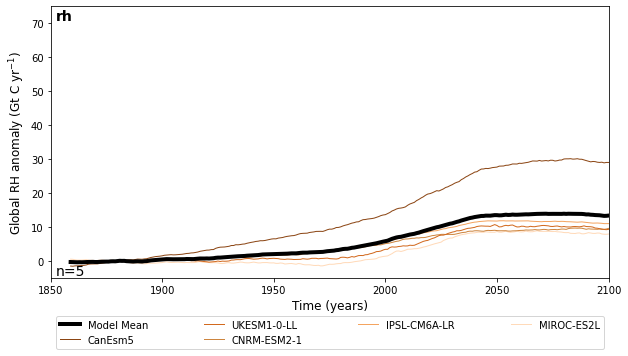

In [29]:
fig,ax = plt.subplots(figsize=(10,5))

grh5_roll.plot(ax=ax, linewidth=1, color= 'peachpuff', label='MIROC-ES2L')
grh4_roll.plot(ax=ax, linewidth=1, color= 'sandybrown', label='IPSL-CM6A-LR')
grh3_roll.plot(ax=ax, linewidth=1, color= 'peru', label='CNRM-ESM2-1')
grh2_roll.plot(ax=ax, linewidth=1, color= 'chocolate', label='UKESM1-0-LL')
grh1_roll.plot(ax=ax, linewidth=1, color= 'saddlebrown', label='CanEsm5')

# adding model mean
modelmean.plot(ax=ax, linewidth=4, color= 'black', label= 'Model Mean')

#add right colors
#N = 5
#plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.RdYlGn(np.linspace(0,1,N)))

# set titel and name for axes
# plt.title('SSP1-1.9', fontsize = 14, fontweight = 'bold')
ax.text(0.01, 0.95, 'rh', 
        transform=ax.transAxes, ha="left", fontsize= 14, fontweight = 'bold')
ax.text(0.009, 0.01, 'n=5', 
        transform=ax.transAxes, ha="left", fontsize= 14)
plt.xlabel('Time (years)', fontsize = 12)
plt.ylabel(r'Global RH anomaly (Gt C yr$^{\minus1}$)', fontsize = 12)
plt.xlim([1850,2100])
plt.ylim([-5,75])


# plotting legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(0, -0.12, 1, 0), loc="upper left", mode="expand", ncol=4)

plt.savefig("TimeSeriesMultiModelCarbonChanges119.png", bbox_inches="tight")
plt.show();

In [20]:
max_rh = max(modelmean)  # Find the maximum y value
max_year = modelmean[modelmean.argmax()]  # Find the x value corresponding to the maximum y value
print (max_year, max_rh)

<xarray.DataArray 'Global-mean RH relative to 1850-1900 in GtC/yr' ()>
array(13.98057638)
Coordinates:
    year     int64 2071 <xarray.DataArray 'Global-mean RH relative to 1850-1900 in GtC/yr' ()>
array(nan)
Coordinates:
    year     int64 1850


In [21]:
modelmean.sel(year=slice('2025','2035'))

<xarray.DataArray 'Global-mean RH relative to 1850-1900 in GtC/yr' (year: 11)>
array([10.29628912, 10.49196301, 10.67287967, 10.87118321, 11.04229194,
       11.15542157, 11.35968983, 11.56912576, 11.72989977, 11.96754133,
       12.15449154])
Coordinates:
  * year     (year) int64 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035

In [22]:
modelmean.sel(year=slice('2025','2035')).mean()

<xarray.DataArray 'Global-mean RH relative to 1850-1900 in GtC/yr' ()>
array(11.21007061)

In [23]:
modelmean.sel(year=slice('2049','2059'))

<xarray.DataArray 'Global-mean RH relative to 1850-1900 in GtC/yr' (year: 11)>
array([13.56617988, 13.55404065, 13.49131407, 13.50804627, 13.59578552,
       13.68475681, 13.6076384 , 13.6357835 , 13.72364757, 13.67077641,
       13.66769777])
Coordinates:
  * year     (year) int64 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059

In [24]:
modelmean.sel(year=slice('2049','2059')).mean()

<xarray.DataArray 'Global-mean RH relative to 1850-1900 in GtC/yr' ()>
array(13.60960608)

In [25]:
modelmean.sel(year=slice('2090','2100'))

<xarray.DataArray 'Global-mean RH relative to 1850-1900 in GtC/yr' (year: 11)>
array([13.76301682, 13.77579456, 13.68098441, 13.64705876, 13.57924286,
       13.55009447, 13.51884255, 13.42830553, 13.33374456, 13.35758607,
       13.42804188])
Coordinates:
  * year     (year) int64 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100

In [26]:
modelmean.sel(year=slice('2090','2100')).mean()

<xarray.DataArray 'Global-mean RH relative to 1850-1900 in GtC/yr' ()>
array(13.55115568)

In [27]:
modelmean.sel(year=slice('2027','2037'))

<xarray.DataArray 'Global-mean RH relative to 1850-1900 in GtC/yr' (year: 11)>
array([10.67287967, 10.87118321, 11.04229194, 11.15542157, 11.35968983,
       11.56912576, 11.72989977, 11.96754133, 12.15449154, 12.33788467,
       12.5569894 ])
Coordinates:
  * year     (year) int64 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037

In [28]:
modelmean.sel(year=slice('2027','2037')).mean()

<xarray.DataArray 'Global-mean RH relative to 1850-1900 in GtC/yr' ()>
array(11.58339988)